# Taylor diagram for pattern correlation
https://gist.github.com/ycopin/3342888

In [1]:
# To reload external files automatically (ex: utils)
%load_ext autoreload
%autoreload 2

import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import proplot as plot # New plot library (https://proplot.readthedocs.io/en/latest/)
plot.rc['savefig.dpi'] = 300 # 1200 is too big! #https://proplot.readthedocs.io/en/latest/basics.html#Creating-figures
from scipy import stats
import xesmf as xe # For regridding (https://xesmf.readthedocs.io/en/latest/)

import sys
sys.path.insert(1, '/home/mlalande/notebooks/utils') # to include my util file in previous directory
import utils as u # my personal functions
u.check_python_version()
# u.check_virtual_memory()

3.8.5 | packaged by conda-forge | (default, Jul 24 2020, 01:25:15) 
[GCC 7.5.0]


## Set variables

In [2]:
period = slice('1979','2014')
latlim, lonlim = u.get_domain_HMA()
# seasons = ['DJFMA', 'JJAS']
seasons = ['Annual']

# Make a extended version for regridding properly on the edges
latlim_ext, lonlim_ext = slice(latlim.start-5, latlim.stop+5), slice(lonlim.start-5, lonlim.stop+5)

# Get zone limits for annual cycle
lonlim_HK, latlim_HK, lonlim_HM, latlim_HM, lonlim_TP, latlim_TP = u.get_zones()

# HMA for full domain and the following for the above zones
zones = ['HMA', 'HK', 'HM', 'TP']
zones_df = pd.DataFrame(
    [[lonlim, latlim], [lonlim_HK, latlim_HK], [lonlim_HM, latlim_HM], [lonlim_TP, latlim_TP]], 
    columns=pd.Index(['lonlim', 'latlim'], name='Limits'),
    index=pd.Index(zones, name='Zones')
)

## Load topography

In [3]:
ds = xr.open_dataset('GMTED2010_15n240_1000deg.nc').drop_dims('nbounds').swap_dims(
    {'nlat': 'latitude', 'nlon': 'longitude'}).drop({'nlat', 'nlon'}).rename(
    {'latitude': 'lat', 'longitude': 'lon'}).sel(lat=latlim_ext, lon=lonlim_ext)
elevation = ds.elevation
elevation_std = ds.elevation_stddev

## Load obs
cru_ts4.00: https://crudata.uea.ac.uk/cru/data/hrg/

In [4]:
obs_longname = 'CRU TS v. 4.00'
obs_name = 'CRU'

obs = xr.open_dataset('/bdd/cru/cru_ts_4.00/data/tmp/cru_ts4.00.1901.2015.tmp.dat.nc').sel(
    time=period, lat=latlim_ext, lon=lonlim_ext).tmp

# Check if the time steps are ok
np.testing.assert_equal((int(period.stop) - int(period.start) + 1)*12, obs.time.size)

## Regrid obs towards the elevation grid of 1°x1°
Using xESMF (https://xesmf.readthedocs.io/en/latest/)

In [5]:
regridder = xe.Regridder(obs, elevation, 'bilinear', periodic=False, reuse_weights=True)
obs_tas = regridder(obs)

Reuse existing file: bilinear_70x120_35x60.nc


## ERA-Interim and ERA5
Downloaded from https://cds.climate.copernicus.eu/cdsapp#!/dataset/ecv-for-climate-change?tab=doc (there are correction but doesn't seem to affect HMA)

For Snow Cover Extent, there is only ERA-Interim on the period 1979-2014 and is computed from snow depth (Appendix A : https://tc.copernicus.org/articles/13/2221/2019/) and https://confluence.ecmwf.int/display/CKB/ERA-Interim%3A+documentation#ERAInterim:documentation-Computationofnear-surfacehumidityandsnowcover

In [6]:
path = '/data/mlalande/ERA-ECV/NETCDF'

In [7]:
tas_era5 = xr.open_dataset(path+'/1month_mean_Global_ea_2t_1979-2014_v02.nc').t2m.rename({'latitude': 'lat', 'longitude': 'lon'}).sel(lat=slice(latlim_ext.stop, latlim_ext.start), lon=lonlim_ext) - 273.15
tas_erai = xr.open_dataset(path+'/1month_mean_Global_ei_t2m_1979-2014_v02.nc').t2m.rename({'latitude': 'lat', 'longitude': 'lon'}).sel(lat=slice(latlim_ext.stop, latlim_ext.start), lon=lonlim_ext) - 273.15
pr_era5 = xr.open_dataset(path+'/1month_mean_Global_ea_tp_1979-2014_v02.nc').tp.rename({'latitude': 'lat', 'longitude': 'lon'}).sel(lat=slice(latlim_ext.stop, latlim_ext.start), lon=lonlim_ext) * 10**3
pr_erai = xr.open_dataset(path+'/1month_mean_Global_ei_tp_1979-2014_v02.nc').tp.rename({'latitude': 'lat', 'longitude': 'lon'}).sel(lat=slice(latlim_ext.stop, latlim_ext.start), lon=lonlim_ext) * 10**3

In [8]:
regridder = xe.Regridder(tas_era5, elevation, 'bilinear', periodic=False, reuse_weights=True)
    
tas_era5_regrid = regridder(tas_era5)
tas_erai_regrid = regridder(tas_erai)
pr_era5_regrid = regridder(pr_era5)
pr_erai_regrid = regridder(pr_erai)

Reuse existing file: bilinear_141x241_35x60.nc


### Snow Cover

In [9]:
ds_rutger = xr.open_dataset('/data/mlalande/RUTGERS/nhsce_v01r01_19661004_20191202.nc').sel(time=period)
with xr.set_options(keep_attrs=True): # Get the snc variable, keep only land data and convert to %
    obs = ds_rutger.snow_cover_extent.where(ds_rutger.land == 1)*100   
obs.attrs['units'] = '%'
obs = obs.rename({'longitude': 'lon', 'latitude': 'lat'}) # Rename lon and lat for the regrid

# Resamble data per month (from per week)
obs = obs.resample(time='1MS').mean('time', skipna=False, keep_attrs=True)

# Check if the time steps are ok
np.testing.assert_equal((int(period.stop) - int(period.start) + 1)*12, obs.time.size)

/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/common.py:1123: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  grouper = pd.Grouper(


In [10]:
import scipy

def add_matrix_NaNs(regridder):
        X = regridder.weights
        M = scipy.sparse.csr_matrix(X)
        num_nonzeros = np.diff(M.indptr)
        M[num_nonzeros == 0, 0] = np.NaN
        regridder.weights = scipy.sparse.coo_matrix(M)
        return regridder

regridder = xe.Regridder(obs, elevation, 'bilinear', periodic=False, reuse_weights=True)
regridder = add_matrix_NaNs(regridder)
obs_snc = regridder(obs)

Reuse existing file: bilinear_88x88_35x60.nc


/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/scipy/sparse/_index.py:124: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


### ERA-Interim SCF

In [11]:
SD = xr.open_mfdataset('/bdd/ERAI/NETCDF/GLOBAL_075/1xmonthly/AN_SF/*/sd.*.asmei.GLOBAL_075.nc').sd.sel(time=period, lat=slice(latlim_ext.stop, latlim_ext.start), lon=lonlim_ext)
RW = 1000
obs = xr.ufuncs.minimum(1, RW*SD/15)*100

# Check if the time steps are ok
np.testing.assert_equal((int(period.stop) - int(period.start) + 1)*12, obs.time.size)

regridder = xe.Regridder(obs, elevation, 'bilinear', periodic=False, reuse_weights=True)
snc_erai_regrid = regridder(obs.load())

Reuse existing file: bilinear_47x80_35x60.nc


### ERA5 SCF

In [12]:
# snow water equivalent (ie parameter SD (141.128))
SD = xr.open_mfdataset('/data/mlalande/ERA5/ERA5_monthly_HMA-ext_SD_1979-2014.nc').sd.rename({'latitude': 'lat', 'longitude': 'lon'}).sel(time=period, lat=slice(latlim_ext.stop, latlim_ext.start), lon=lonlim_ext)

# RSN is density of snow (parameter 33.128)
RSN = xr.open_dataset('/data/mlalande/ERA5/ERA5_monthly_HMA-ext_RSN_1979-2014.nc').rsn.rename({'latitude': 'lat', 'longitude': 'lon'}).sel(time=period, lat=slice(latlim_ext.stop, latlim_ext.start), lon=lonlim_ext)

#  RW is density of water equal to 1000
RW = 1000 

# https://confluence.ecmwf.int/display/CKB/ERA5%3A+data+documentation#ERA5:datadocumentation-Computationofnear-surfacehumidityandsnowcover
obs = xr.ufuncs.minimum(1, (RW*SD/RSN)/0.1) * 100

# Check if the time steps are ok
np.testing.assert_equal((int(period.stop) - int(period.start) + 1)*12, obs.time.size)

regridder = xe.Regridder(obs, elevation, 'bilinear', periodic=False, reuse_weights=True)
snc_era5_regrid = regridder(obs.load())

Reuse existing file: bilinear_141x241_35x60.nc


### Precipitation

#### APHRODITE

In [13]:
obs_longname = 'APHRODITE V1101 (0.5°)'
obs_name = 'APHRODITE'

obs_V1101 = xr.open_mfdataset(
    '/data/mlalande/APHRODITE/APHRO_MA_050deg_V1101.*.nc', combine='by_coords'
).precip
obs_V1101_EXR1 = xr.open_mfdataset(
    '/data/mlalande/APHRODITE/APHRO_MA_050deg_V1101_EXR1.*.nc', combine='by_coords'
).precip

obs_V1101 = obs_V1101.rename({'longitude': 'lon', 'latitude': 'lat'})
obs = (xr.combine_nested([obs_V1101, obs_V1101_EXR1], concat_dim='time')).sel(time=period)

# Resamble data per month (from per day)
obs = obs.resample(time='1MS').mean('time', skipna=False, keep_attrs=True)

# Check if the time steps are ok
np.testing.assert_equal((int(period.stop) - int(period.start) + 1)*12, obs.time.size)

/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/common.py:1123: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  grouper = pd.Grouper(


In [14]:
import scipy

def add_matrix_NaNs(regridder):
        X = regridder.weights
        M = scipy.sparse.csr_matrix(X)
        num_nonzeros = np.diff(M.indptr)
        M[num_nonzeros == 0, 0] = np.NaN
        regridder.weights = scipy.sparse.coo_matrix(M)
        return regridder

regridder = xe.Regridder(obs, elevation, 'bilinear', periodic=False, reuse_weights=True)
regridder = add_matrix_NaNs(regridder)
obs_pr = regridder(obs)

Reuse existing file: bilinear_140x180_35x60.nc


/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/scipy/sparse/_index.py:124: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


#### GPCP

In [15]:
obs_longname = 'GPCP CDR v2.3 (2.5°)'
obs_name = 'GPCP'

obs = xr.open_mfdataset(
    # '/bdd/GPCP/netcdf/surf-rr_gpcp_multi-sat_250d_01mth_*_v2.2-02.nc', combine='by_coords'
    # -> missing some month (ex 2014/11)
    '/data/mlalande/GPCP/CDR_monthly_v2.3/*/gpcp_v02r03_monthly_d*_c20170616.nc'
).precip.sel(time=period, latitude=latlim_ext, longitude=lonlim_ext)

obs = obs.rename({'longitude': 'lon', 'latitude': 'lat'})

# Check if the time steps are ok
np.testing.assert_equal((int(period.stop) - int(period.start) + 1)*12, obs.time.size)

In [16]:
import scipy

def add_matrix_NaNs(regridder):
        X = regridder.weights
        M = scipy.sparse.csr_matrix(X)
        num_nonzeros = np.diff(M.indptr)
        M[num_nonzeros == 0, 0] = np.NaN
        regridder.weights = scipy.sparse.coo_matrix(M)
        return regridder

regridder = xe.Regridder(obs, elevation, 'bilinear', periodic=False, reuse_weights=True)
regridder = add_matrix_NaNs(regridder)
obs_pr_GPCP = regridder(obs.load())

Reuse existing file: bilinear_14x24_35x60.nc


/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/scipy/sparse/_index.py:124: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


## Load data

In [17]:
clim = xr.open_dataarray('results/multimodel_clim_1979-2014.nc')

## Taylor diagram code

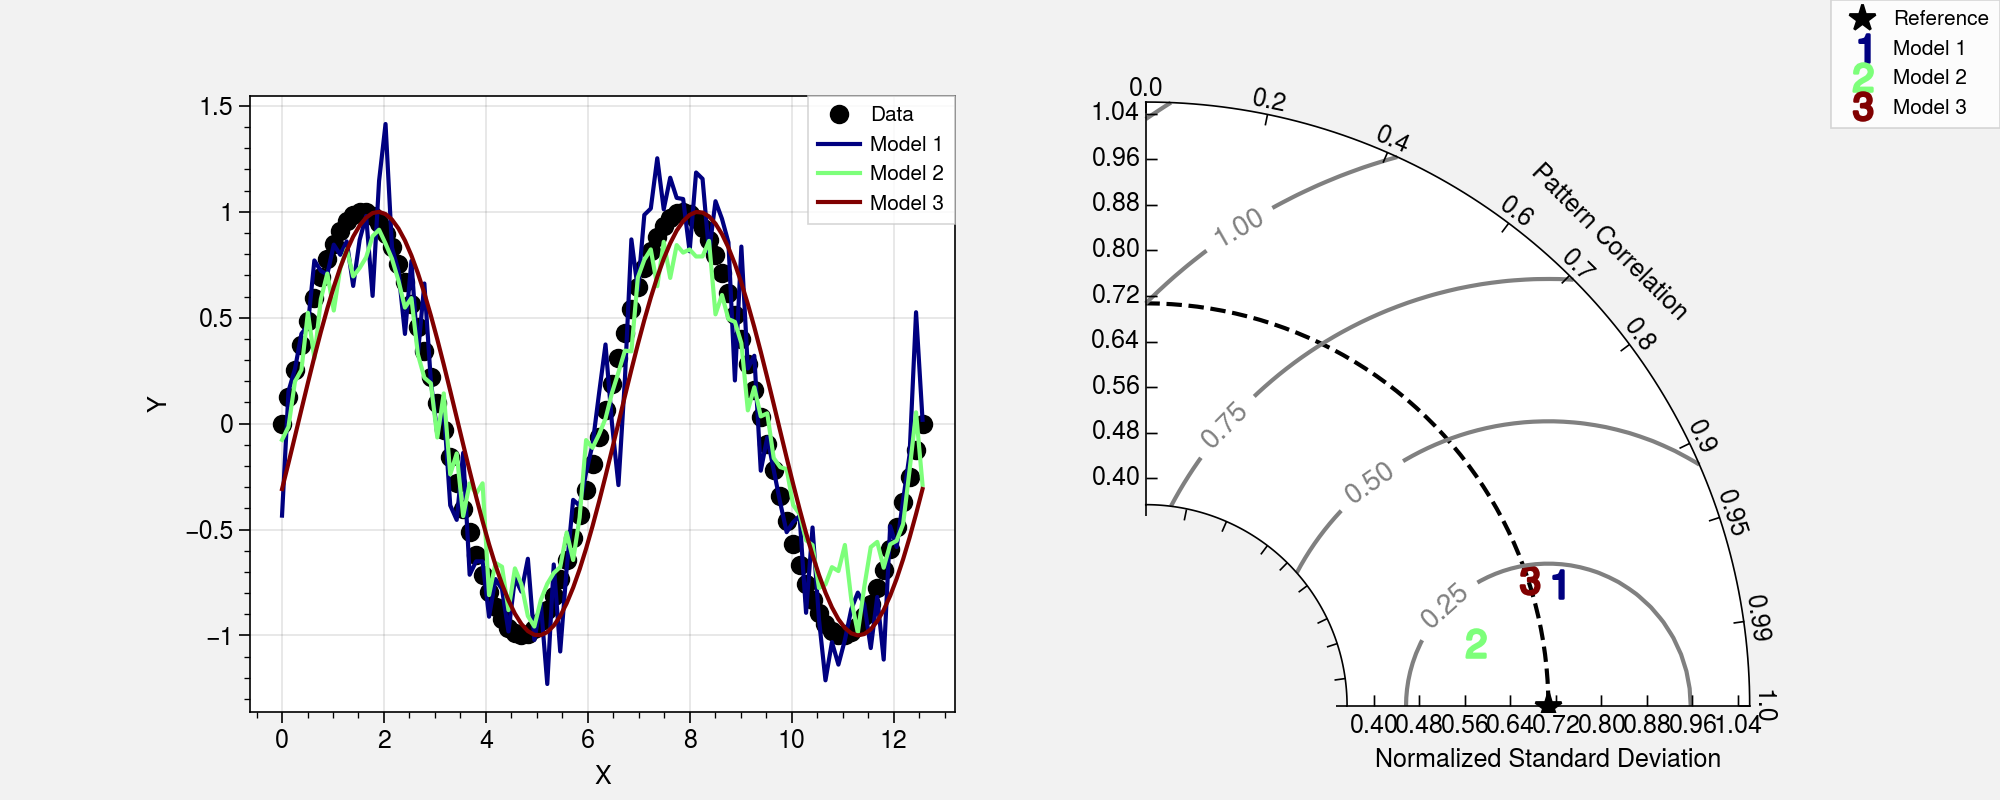

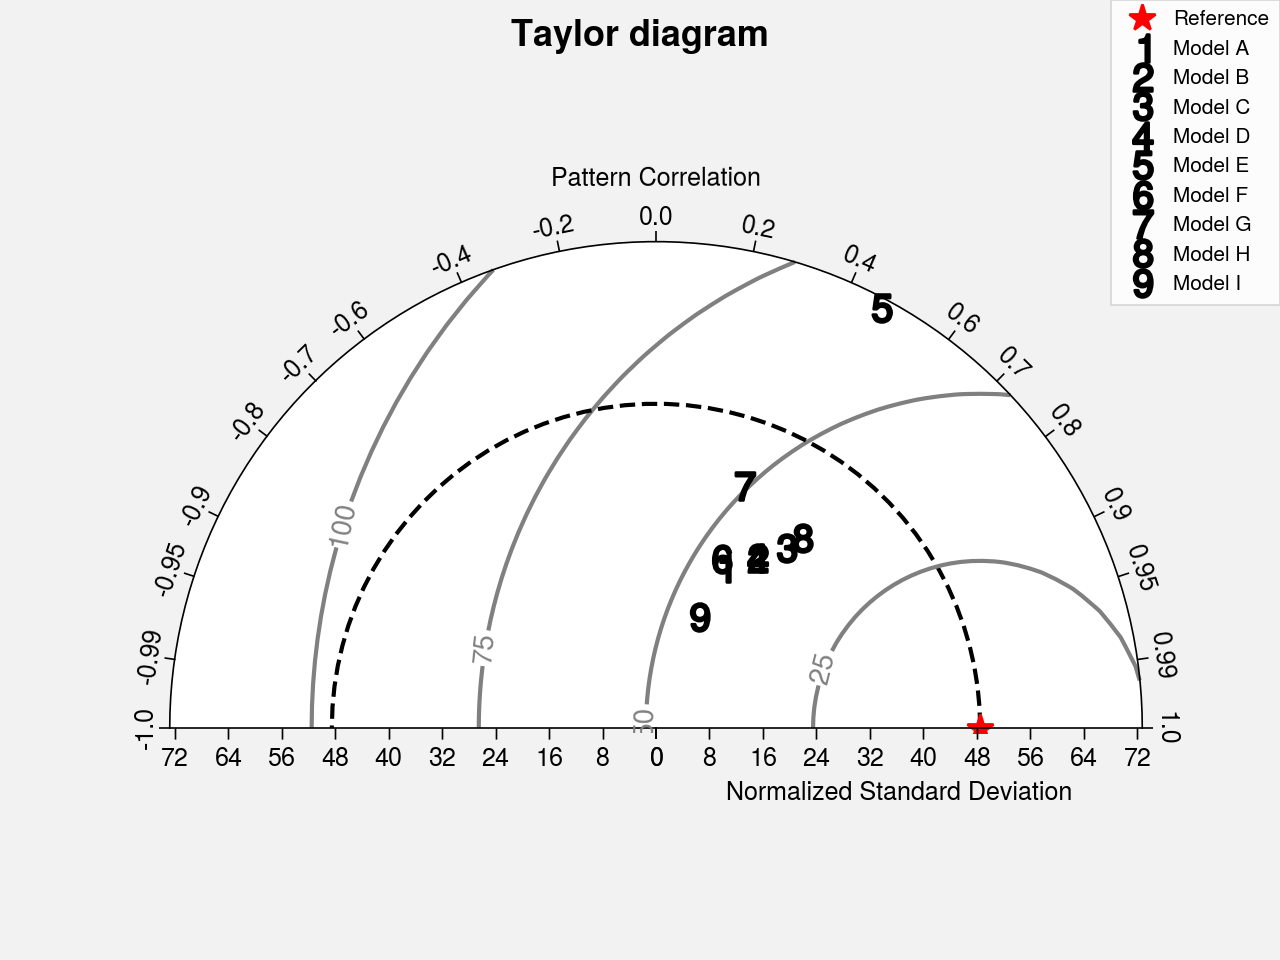

In [18]:
#!/usr/bin/env python
# Copyright: This document has been placed in the public domain.

"""
Taylor diagram (Taylor, 2001) implementation.

Note: If you have found these software useful for your research, I would
appreciate an acknowledgment.
"""

__version__ = "Time-stamp: <2018-12-06 11:43:41 ycopin>"
__author__ = "Yannick Copin <yannick.copin@laposte.net>"

import numpy as NP
import matplotlib.pyplot as PLT


class TaylorDiagram(object):
    """
    Taylor diagram.

    Plot model standard deviation and correlation to reference (data)
    sample in a single-quadrant polar plot, with r=stddev and
    theta=arccos(correlation).
    """

    def __init__(self, refstd,
                 fig=None, rect=111, label='_', srange=(0, 1.5), extend=False):
        """
        Set up Taylor diagram axes, i.e. single quadrant polar
        plot, using `mpl_toolkits.axisartist.floating_axes`.

        Parameters:

        * refstd: reference standard deviation to be compared to
        * fig: input Figure or None
        * rect: subplot definition
        * label: reference label
        * srange: stddev axis extension, in units of *refstd*
        * extend: extend diagram to negative correlations
        """

        from matplotlib.projections import PolarAxes
        import mpl_toolkits.axisartist.floating_axes as FA
        import mpl_toolkits.axisartist.grid_finder as GF

        self.refstd = refstd            # Reference standard deviation

        tr = PolarAxes.PolarTransform()

        # Correlation labels
        rlocs = NP.array([0, 0.2, 0.4, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99, 1])
        if extend:
            # Diagram extended to negative correlations
            self.tmax = NP.pi
            rlocs = NP.concatenate((-rlocs[:0:-1], rlocs))
        else:
            # Diagram limited to positive correlations
            self.tmax = NP.pi/2
        tlocs = NP.arccos(rlocs)        # Conversion to polar angles
        gl1 = GF.FixedLocator(tlocs)    # Positions
        tf1 = GF.DictFormatter(dict(zip(tlocs, map(str, rlocs))))

        # Standard deviation axis extent (in units of reference stddev)
        self.smin = srange[0] * self.refstd
        self.smax = srange[1] * self.refstd

        ghelper = FA.GridHelperCurveLinear(
            tr,
            extremes=(0, self.tmax, self.smin, self.smax),
            grid_locator1=gl1, tick_formatter1=tf1)

        if fig is None:
            fig = PLT.figure()

        ax = FA.FloatingSubplot(fig, rect, grid_helper=ghelper)
        fig.add_subplot(ax)

        # Adjust axes
        ax.axis["top"].set_axis_direction("bottom")   # "Angle axis"
        ax.axis["top"].toggle(ticklabels=True, label=True)
        ax.axis["top"].major_ticklabels.set_axis_direction("top")
        ax.axis["top"].label.set_axis_direction("top")
        ax.axis["top"].label.set_text("Pattern Correlation")

        ax.axis["left"].set_axis_direction("bottom")  # "X axis"
        ax.axis["left"].label.set_text("Normalized Standard Deviation")

        ax.axis["right"].set_axis_direction("top")    # "Y-axis"
        ax.axis["right"].toggle(ticklabels=True)
        ax.axis["right"].major_ticklabels.set_axis_direction(
            "bottom" if extend else "left")

        if self.smin:
            ax.axis["bottom"].toggle(ticklabels=False, label=False)
        else:
            ax.axis["bottom"].set_visible(False)          # Unused

        self._ax = ax                   # Graphical axes
        self.ax = ax.get_aux_axes(tr)   # Polar coordinates

        # Add reference point and stddev contour
        l, = self.ax.plot([0], self.refstd, 'k*',
                          ls='', ms=10, label=label)
        t = NP.linspace(0, self.tmax)
        r = NP.zeros_like(t) + self.refstd
        self.ax.plot(t, r, 'k--', label='_')

        # Collect sample points for latter use (e.g. legend)
        self.samplePoints = [l]

    def add_sample(self, stddev, corrcoef, *args, **kwargs):
        """
        Add sample (*stddev*, *corrcoeff*) to the Taylor
        diagram. *args* and *kwargs* are directly propagated to the
        `Figure.plot` command.
        """

        l, = self.ax.plot(NP.arccos(corrcoef), stddev,
                          *args, **kwargs)  # (theta, radius)
        self.samplePoints.append(l)

        return l

    def add_grid(self, *args, **kwargs):
        """Add a grid."""

        self._ax.grid(*args, **kwargs)

    def add_contours(self, levels=5, **kwargs):
        """
        Add constant centered RMS difference contours, defined by *levels*.
        """

        rs, ts = NP.meshgrid(NP.linspace(self.smin, self.smax),
                             NP.linspace(0, self.tmax))
        # Compute centered RMS difference
        rms = NP.sqrt(self.refstd**2 + rs**2 - 2*self.refstd*rs*NP.cos(ts))

        contours = self.ax.contour(ts, rs, rms, levels, **kwargs)

        return contours


def test1():
    """Display a Taylor diagram in a separate axis."""

    # Reference dataset
    x = NP.linspace(0, 4*NP.pi, 100)
    data = NP.sin(x)
    refstd = data.std(ddof=1)           # Reference standard deviation

    # Generate models
    m1 = data + 0.2*NP.random.randn(len(x))     # Model 1
    m2 = 0.8*data + .1*NP.random.randn(len(x))  # Model 2
    m3 = NP.sin(x-NP.pi/10)                     # Model 3

    # Compute stddev and correlation coefficient of models
    samples = NP.array([ [m.std(ddof=1), NP.corrcoef(data, m)[0, 1]]
                         for m in (m1, m2, m3)])

    fig = PLT.figure(figsize=(10, 4))

    ax1 = fig.add_subplot(1, 2, 1, xlabel='X', ylabel='Y')
    # Taylor diagram
    dia = TaylorDiagram(refstd, fig=fig, rect=122, label="Reference",
                        srange=(0.5, 1.5))

    colors = PLT.matplotlib.cm.jet(NP.linspace(0, 1, len(samples)))

    ax1.plot(x, data, 'ko', label='Data')
    for i, m in enumerate([m1, m2, m3]):
        ax1.plot(x, m, c=colors[i], label='Model %d' % (i+1))
    ax1.legend(numpoints=1, prop=dict(size='small'), loc='best')

    # Add the models to Taylor diagram
    for i, (stddev, corrcoef) in enumerate(samples):
        dia.add_sample(stddev, corrcoef,
                       marker='$%d$' % (i+1), ms=10, ls='',
                       mfc=colors[i], mec=colors[i],
                       label="Model %d" % (i+1))

    # Add grid
    dia.add_grid()

    # Add RMS contours, and label them
    contours = dia.add_contours(colors='0.5')
    PLT.clabel(contours, inline=1, fontsize=10, fmt='%.2f')

    # Add a figure legend
    fig.legend(dia.samplePoints,
               [ p.get_label() for p in dia.samplePoints ],
               numpoints=1, prop=dict(size='small'), loc='upper right')

    return dia


def test2():
    """
    Climatology-oriented example (after iteration w/ Michael A. Rawlins).
    """

    # Reference std
    stdref = 48.491

    # Samples std,rho,name
    samples = [[25.939, 0.385, "Model A"],
               [29.593, 0.509, "Model B"],
               [33.125, 0.585, "Model C"],
               [29.593, 0.509, "Model D"],
               [71.215, 0.473, "Model E"],
               [27.062, 0.360, "Model F"],
               [38.449, 0.342, "Model G"],
               [35.807, 0.609, "Model H"],
               [17.831, 0.360, "Model I"]]

    fig = PLT.figure()

    dia = TaylorDiagram(stdref, fig=fig, label='Reference', extend=True)
    dia.samplePoints[0].set_color('r')  # Mark reference point as a red star

    # Add models to Taylor diagram
    for i, (stddev, corrcoef, name) in enumerate(samples):
        dia.add_sample(stddev, corrcoef,
                       marker='$%d$' % (i+1), ms=10, ls='',
                       mfc='k', mec='k',
                       label=name)

    # Add RMS contours, and label them
    contours = dia.add_contours(levels=5, colors='0.5')  # 5 levels in grey
    PLT.clabel(contours, inline=1, fontsize=10, fmt='%.0f')

    dia.add_grid()                                  # Add grid
    dia._ax.axis[:].major_ticks.set_tick_out(True)  # Put ticks outward

    # Add a figure legend and title
    fig.legend(dia.samplePoints,
               [ p.get_label() for p in dia.samplePoints ],
               numpoints=1, prop=dict(size='small'), loc='upper right')
    fig.suptitle("Taylor diagram", size='x-large')  # Figure title

    return dia


if __name__ == '__main__':

    dia = test1()
    dia = test2()

    PLT.show()

## Make functions for making weighted metrics

In [19]:
def m(x, w):
    """Weighted Mean"""
    return np.sum(x * w) / np.sum(w)

def cov(x, y, w):
    """Weighted Covariance"""
    return np.sum(w * (x - m(x, w)) * (y - m(y, w))) / np.sum(w)

def corr(x, y, w):
    """Weighted Correlation"""
    return cov(x, y, w) / np.sqrt(cov(x, x, w) * cov(y, y, w))

def std(x, w):
    """Weighted Standard Deviation"""
    return np.sqrt(cov(x, x, w))

def crmse(x, y, w):
    """Weighted Standard Deviation"""
    xc = x - m(x, w)
    yc = y - m(y, w)
    
    return np.sqrt(np.sum(w * (xc - yc)**2 / np.sum(w)))

In [20]:
w = elevation.sel(lat=latlim, lon=lonlim).copy()

for i, lat in enumerate(elevation.sel(lat=latlim, lon=lonlim).lat):
    w[i] = lat
#     w[i] = np.cos(np.deg2rad(lat))
    
w = np.cos(np.deg2rad(w)).where(elevation>2500)
temp = w.values.flatten()
w_array = temp[~np.isnan(temp)]
len(w_array)

339

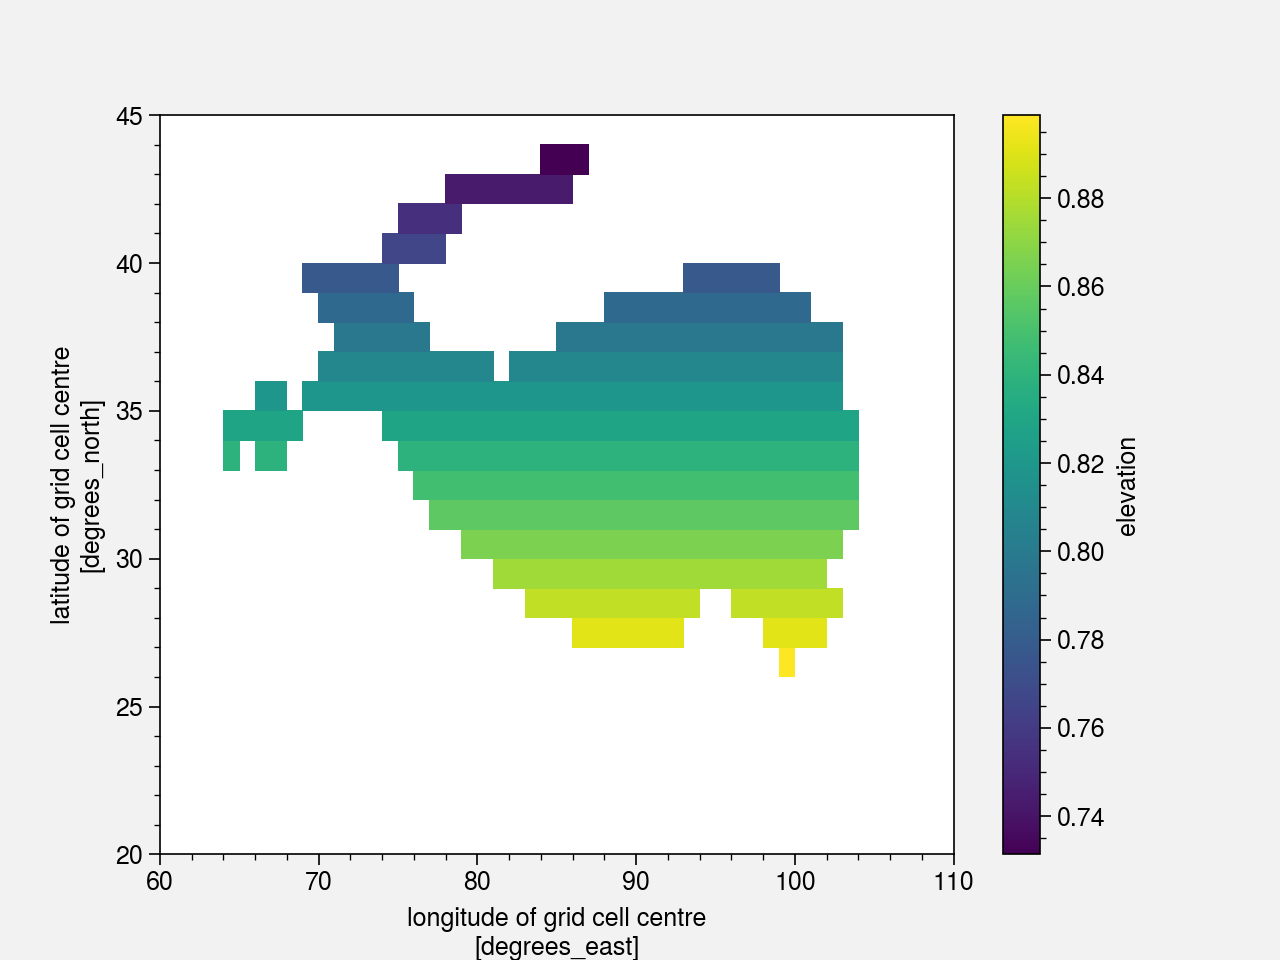

In [21]:
w.plot()

In [22]:
list_models = u.get_model_names()
list_var = ['tas', 'pr', 'snc']
list_obs = [obs_tas, obs_pr, obs_snc]
list_erai = [tas_erai_regrid, pr_erai_regrid, snc_erai_regrid]
list_era5 = [tas_era5_regrid, pr_era5_regrid, snc_era5_regrid]

corr_models = [[None]*len(list_models) for i in range(len(list_var))]
corr_erai = [None]*len(list_var)
corr_era5 = [None]*len(list_var)
corr_MMM = [None]*len(list_var)


std_models = [[None]*len(list_models) for i in range(len(list_var))]
std_erai = [None]*len(list_var)
std_era5 = [None]*len(list_var)
std_MMM = [None]*len(list_var)
std_obs = [None]*len(list_var)

for i_var, var in enumerate(list_var):
    a = u.clim(list_obs[i_var].sel(lat=latlim, lon=lonlim).where(elevation>2500)).values.flatten()
    std_obs[i_var] = std(a[~np.isnan(a)], w_array)

    for i_model, model in enumerate(list_models):
        b = clim.sel(var=var, season='Annual')[i_model].sel(lat=latlim, lon=lonlim).where(elevation>2500).values.flatten()
        std_models[i_var][i_model] = std(b[~np.isnan(b)], w_array)
        corr_models[i_var][i_model] = corr(a[~np.isnan(a)], b[~np.isnan(b)], w_array)
    
    # ERAI
    b = u.clim(list_erai[i_var].sel(lat=latlim, lon=lonlim).where(elevation>2500)).values.flatten()
    std_erai[i_var] = std(b[~np.isnan(b)], w_array)
    corr_erai[i_var] = corr(a[~np.isnan(a)], b[~np.isnan(b)], w_array)

    # ERA5
    b = u.clim(list_era5[i_var].sel(lat=latlim, lon=lonlim).where(elevation>2500)).values.flatten()
    std_era5[i_var] = std(b[~np.isnan(b)], w_array)
    corr_era5[i_var] = corr(a[~np.isnan(a)], b[~np.isnan(b)], w_array)
    
    # MMM
    b = clim.sel(var=var, season='Annual').mean('model').sel(lat=latlim, lon=lonlim).where(elevation>2500).values.flatten()
    std_MMM[i_var] = std(b[~np.isnan(b)], w_array)
    corr_MMM[i_var] = corr(a[~np.isnan(a)], b[~np.isnan(b)], w_array)

In [23]:
# GPCP
a = u.clim(list_obs[1].sel(lat=latlim, lon=lonlim).where(elevation>2500)).values.flatten()
b = u.clim(obs_pr_GPCP.sel(lat=latlim, lon=lonlim).where(elevation>2500)).values.flatten()
corr_GPCP = corr(a[~np.isnan(a)], b[~np.isnan(b)], w_array)

std_GPCP = std(b[~np.isnan(b)], w_array)

In [24]:
n = 5
marker = ['o']*n + ['P']*n + ['s']*n + ['^']*n + ['*']*n + ['x']*n + ['D']*n
mec = ['C'+str(i) for i in range(n)]*6
mfc = ['C'+str(i) for i in range(n)]*2 + [(0, 0, 0, 0)]*30

## Normalized STD

In [37]:
corr_models[2]

[0.4060577108207034,
 -0.048507396055393275,
 0.35304942789671345,
 0.5451450208588552,
 0.18717816824073782,
 0.5664690821563126,
 0.2386532474018692,
 0.36576700126716777,
 0.5067609313160499,
 0.3803684844614817,
 0.12137753290255038,
 0.812498945719181,
 0.4645643234222097,
 0.5010915830604762,
 0.20277179888577787,
 0.3842060466801044,
 0.45419142665035783,
 -0.17044596504338844,
 0.21802920043488072,
 0.6921053336247475,
 0.5469944566179803,
 0.585692217056908,
 0.3671863311017827,
 0.5056714906358571,
 0.49659860836180625,
 0.26985362776902144]

In [39]:
np.max(corr_models[2])

0.812498945719181

In [42]:
i=2
std_MMM[i]/std_obs[i]

0.6682716563812462

In [48]:
1-0.67

0.32999999999999996

In [43]:
corr_MMM[i]

0.48670550952424724

In [44]:
std_erai[i]/std_obs[i]

0.87046514748331

In [45]:
corr_erai[i]

0.9057906127100734

In [46]:
std_era5[i]/std_obs[i]

1.2357024914978523

In [47]:
corr_era5[i]

0.6910091854518065

In [35]:
std_GPCP/std_obs[i]

1.300886874563253

In [36]:
corr_GPCP

0.8379705090788564

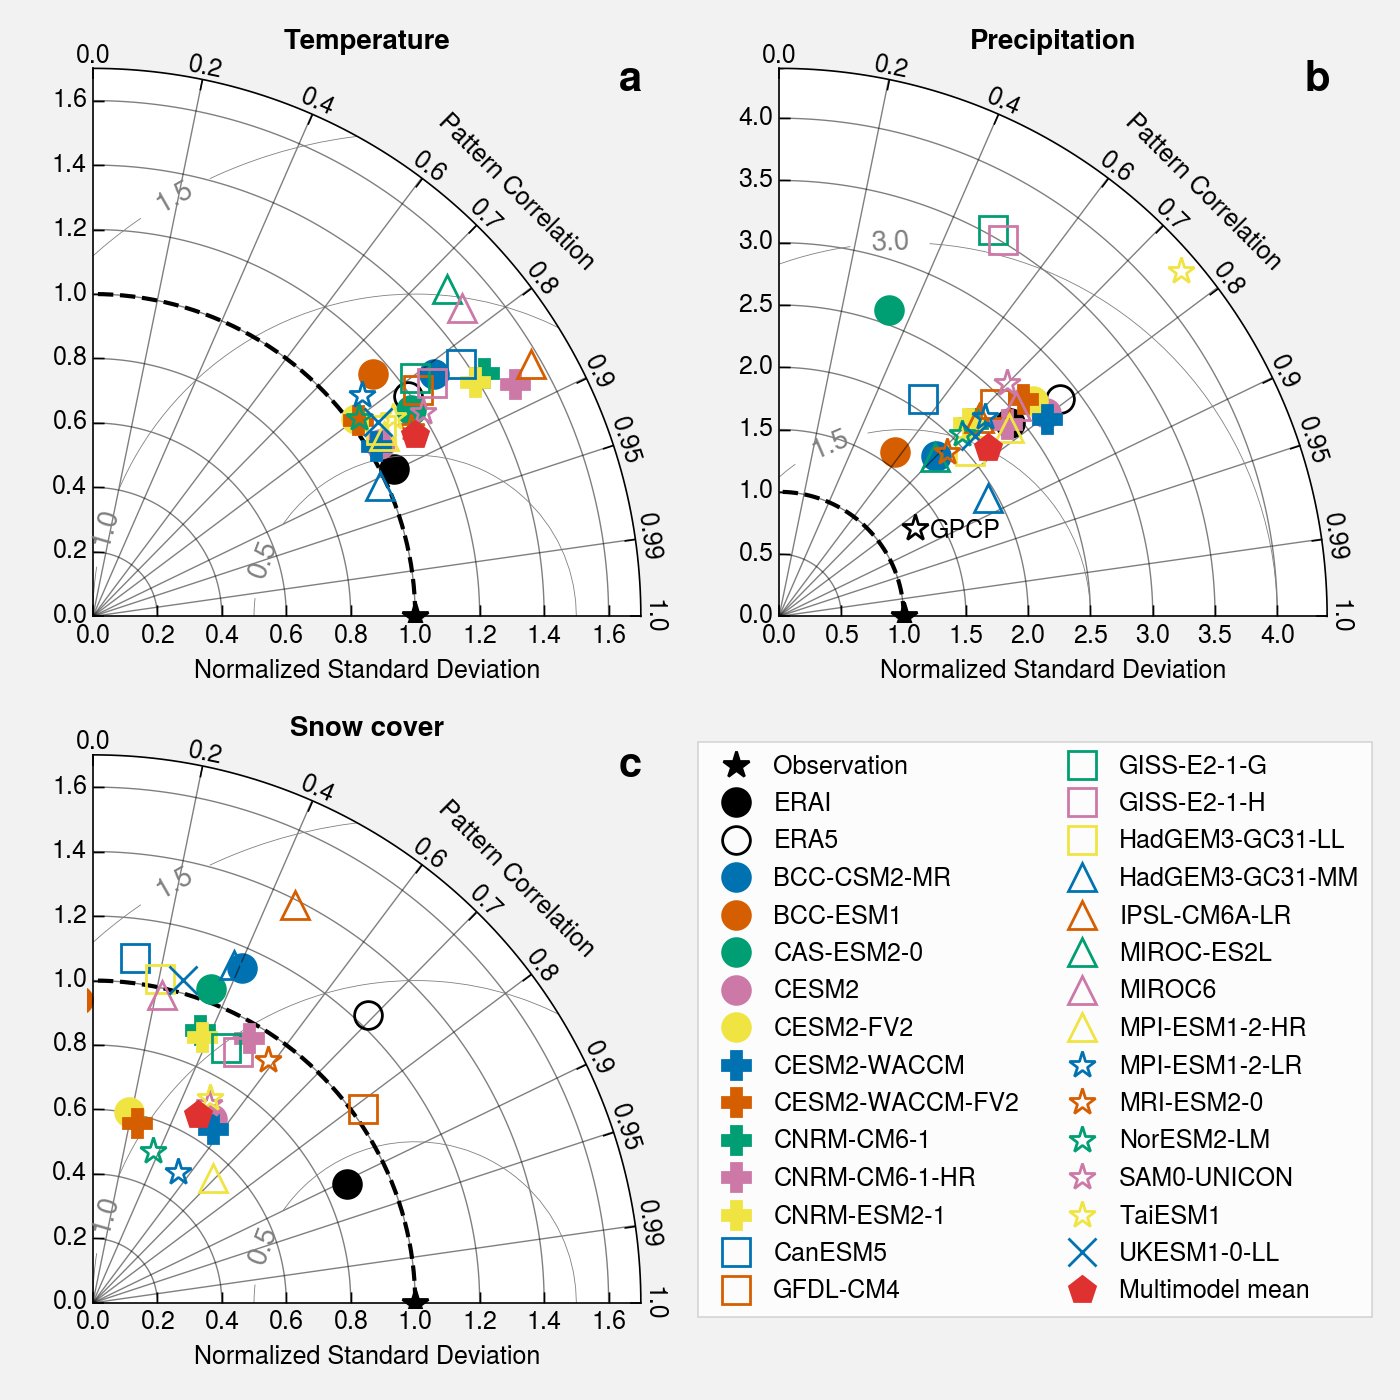

In [41]:
list_var = ['tas', 'pr', 'snc']
list_label = ['Temperature', 'Precipitation', 'Snow cover']
rects = [221, 222, 223]
abc = ['a', 'b', 'c']
srange = [(0, 1.7), (0, 4.4), (0, 1.7)]

fig = PLT.figure(figsize=(7,7))

for i, var in enumerate(list_var):
    dia = TaylorDiagram(std_obs[i]/std_obs[i], fig=fig, rect=rects[i], label='Observation', srange=srange[i], extend=False)
#     dia = TaylorDiagram(std_obs[i], fig=fig, rect=rects[i], label='Observation', srange=(0, 5), extend=True)
    
    # ERA
    dia.add_sample(std_erai[i]/std_obs[i], corr_erai[i], marker='o', ms=10, ls='', mfc='k', mec='k', label='ERAI', zorder=0)
    dia.add_sample(std_era5[i]/std_obs[i], corr_era5[i], marker='o', ms=10, ls='', mfc=(0, 0, 0, 0), mec='k', label='ERA5', zorder=1)
    
    # GPCP
    if var == 'pr':
        dia.add_sample(std_GPCP.item(0)/std_obs[i], corr_GPCP, marker='*', ms=10, ls='', mfc=(0, 0, 0, 0), mec='k', label='GPCP', zorder=1)
        dia._ax.text(0.28, 0.15, 'GPCP', size=9, transform=dia._ax.transAxes)
    
    for j, model in enumerate(list_models):
        dia.add_sample(std_models[i][j]/std_obs[i], corr_models[i][j], marker=marker[j], ms=10, ls='', mfc=mfc[j], mec=mec[j],label=model, zorder=j)
        
    # MMM
    dia.add_sample(std_MMM[i]/std_obs[i], corr_MMM[i], marker='p', ms=10, ls='', mfc='red8', mec='red8', label='Multimodel mean', zorder=30)
        

        
           
    dia._ax.set_title(list_label[i], fontweight="bold")
    dia._ax.text(0.95, 0.95, abc[i], size=15, weight='bold', transform=dia._ax.transAxes)
    
    # Add RMS contours, and label them
    contours = dia.add_contours(levels=3, colors='0.5', linewidths=0.3)  # 5 levels in grey
    PLT.clabel(contours, inline=1, fontsize=10, fmt='%.1f')
    
    # Grid
    dia._ax.grid(lw=0.5, alpha=0.5)


fig.legend(dia.samplePoints,
           [ p.get_label() for p in dia.samplePoints ],
           numpoints=1, bbox_to_anchor=(0.98, 0.47), ncol=2)

# fig.suptitle("Taylor diagram of spatial climatologies "+str(period.start)+"-"+period.stop, size='x-large')  # Figure title

fig.tight_layout()

# for ext in ['jpg', 'png', 'pdf']:
#     fig.savefig('img/fig_taylor_diagram_Annual_PCC_'+str(period.start)+'-'+period.stop+'.'+ext, dpi=300, bbox_inches='tight')

## STD

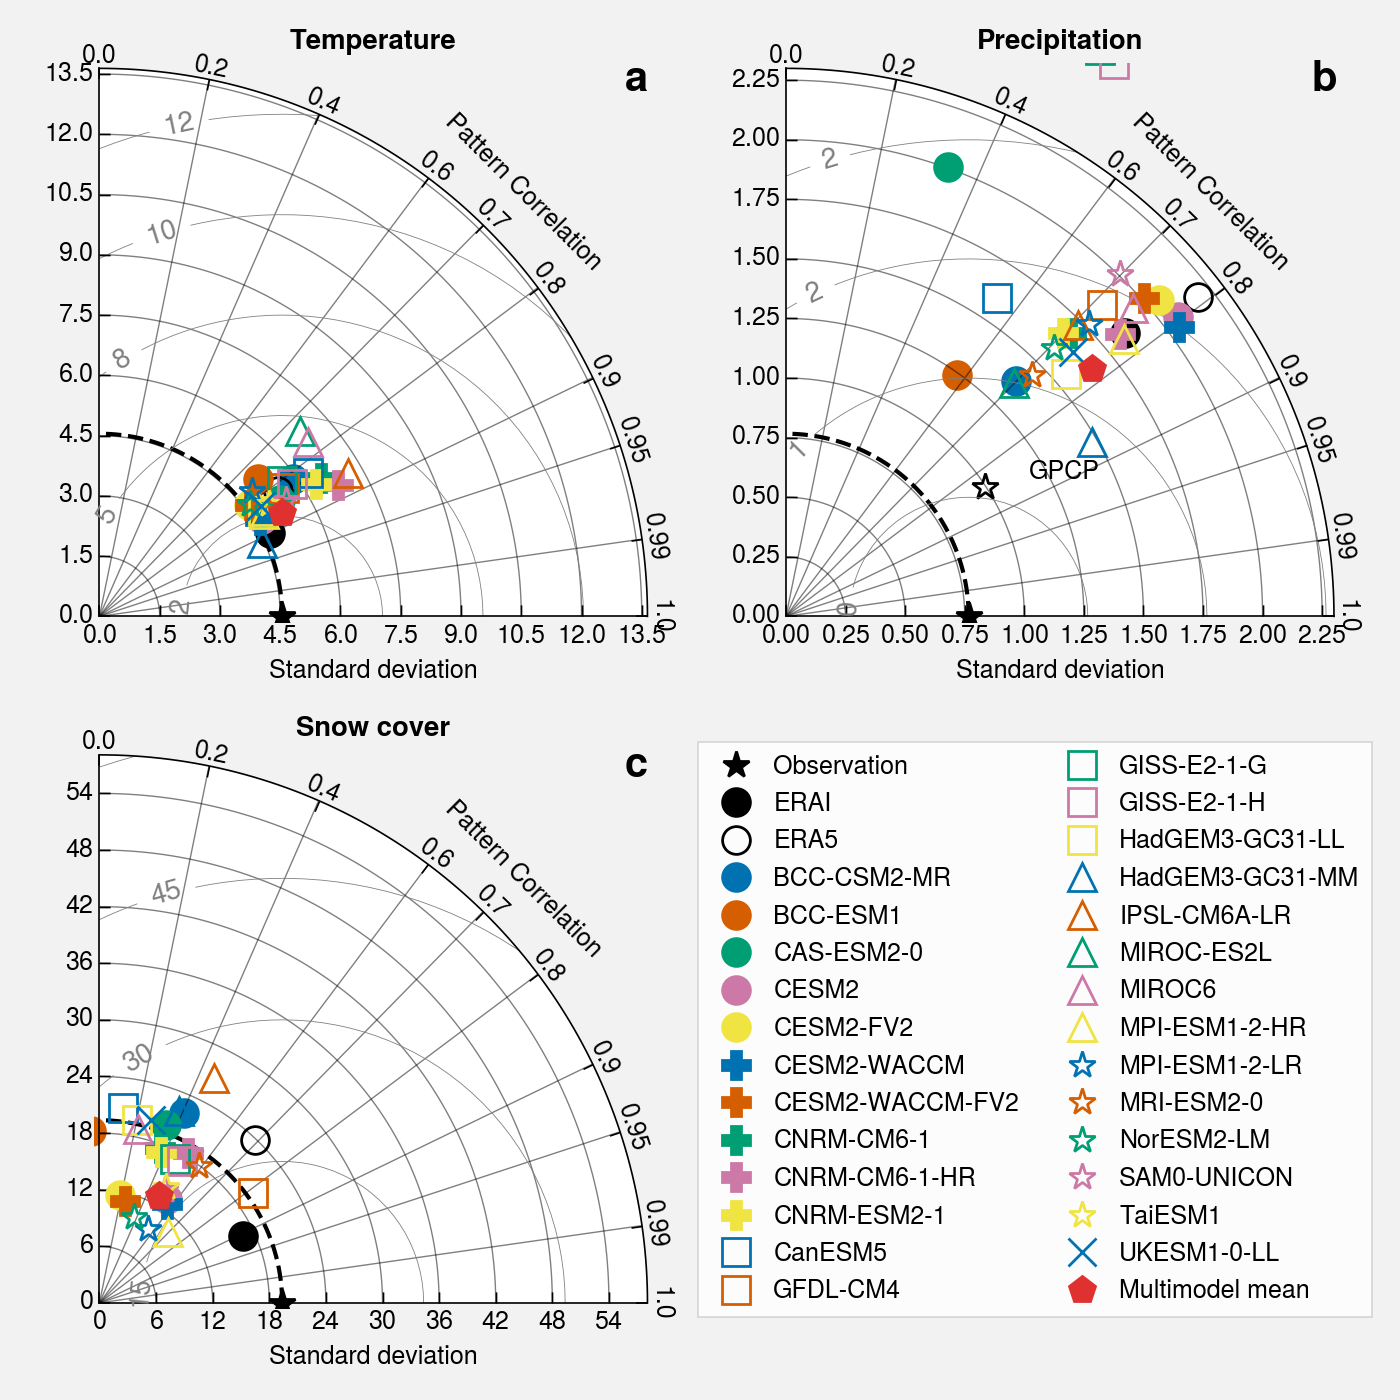

In [162]:
list_var = ['tas', 'pr', 'snc']
list_label = ['Temperature', 'Precipitation', 'Snow cover']
rects = [221, 222, 223]
abc = ['a', 'b', 'c']


fig = PLT.figure(figsize=(7,7))

for i, var in enumerate(list_var):
    dia = TaylorDiagram(std_obs[i], fig=fig, rect=rects[i], label='Observation', srange=(0, 3))
#     dia = TaylorDiagram(std_obs[i], fig=fig, rect=rects[i], label='Observation', srange=(0, 5), extend=True)
    
    # ERA
    dia.add_sample(std_erai[i], corr_erai[i], marker='o', ms=10, ls='', mfc='k', mec='k', label='ERAI', zorder=0)
    dia.add_sample(std_era5[i], corr_era5[i], marker='o', ms=10, ls='', mfc=(0, 0, 0, 0), mec='k', label='ERA5', zorder=1)
    
    # GPCP
    if var == 'pr':
        dia.add_sample(std_GPCP.item(0), corr_GPCP, marker='*', ms=10, ls='', mfc=(0, 0, 0, 0), mec='k', label='GPCP', zorder=1)
        dia._ax.text(0.445, 0.255, 'GPCP', size=9, transform=dia._ax.transAxes)
    
    for j, model in enumerate(list_models):
        dia.add_sample(std_models[i][j], corr_models[i][j], marker=marker[j], ms=10, ls='', mfc=mfc[j], mec=mec[j],label=model, zorder=j)
        
    # MMM
    dia.add_sample(std_MMM[i], corr_MMM[i], marker='p', ms=10, ls='', mfc='red8', mec='red8', label='Multimodel mean', zorder=30)
        

        
           
    dia._ax.set_title(list_label[i], fontweight="bold")
    dia._ax.text(0.95, 0.95, abc[i], size=15, weight='bold', transform=dia._ax.transAxes)
    
    # Add RMS contours, and label them
    contours = dia.add_contours(levels=5, colors='0.5', linewidths=0.3)  # 5 levels in grey
    PLT.clabel(contours, inline=1, fontsize=10, fmt='%.0f')
    
    # Grid
    dia._ax.grid(lw=0.5, alpha=0.5)


fig.legend(dia.samplePoints,
           [ p.get_label() for p in dia.samplePoints ],
           numpoints=1, bbox_to_anchor=(0.98, 0.47), ncol=2)

fig.tight_layout()

# for ext in ['jpg', 'png', 'pdf']:
#     fig.savefig('img/fig_taylor_diagram.'+ext, dpi=300, bbox_inches='tight')

- Faire un std normalisée et changer le srange pour snc et tas
- attention noter les points hors des graphes
- à refaire pour AC